In [150]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.colors
import statsmodels.formula.api as smf
import seaborn as sns
from cem.match import match
from cem.coarsen import coarsen
from cem.imbalance import L1
import statsmodels.api as sm


In [3]:

pop_df=pd.read_csv(r'C:\Users\Yasaman\Downloads\World_bank_population.csv',skiprows=3)
pop_df['Country Code']=pop_df['Country Code'].apply(lambda x: x.lower())
possible_countries=pop_df.query(" `2019` >=1000000")['Country Code'].values

excluded_iso3_codes = [
    "IRL",  # Ireland
    "SSD",  # South Sudan
    "SDN",  # Sudan
    "COG",  # Republic of the Congo
    "COD",  # Democratic Republic of the Congo
    "GIN",  # Guinea
    "GNB",  # Guinea-Bissau
    "GNQ",  # Equatorial Guinea
    "PNG",  # Papua New Guinea
    "XKX",  # Kosovo (unofficial)
    "MNE",  # Montenegro
    "SRB",  # Serbia
    "TLS",   # Timor-Leste
    "GEO", #Georgia
    'SWZ', 
    'PRK', #North Korea
]
excluded_iso3_codes=[c.lower() for c in excluded_iso3_codes]


possible_iso=list(set(possible_countries)-set(excluded_iso3_codes))

# Domestic attention

In [170]:

df = pd.read_csv(r"C:\Users\Yasaman\Downloads\Attention-fractional counting.csv")
df.rename(columns={'aggregated_value': 'count', 'country': 'Mention_country', 'affiliation_country': 'Aff_country'}, inplace=True)
df = df[df['year'].isin(np.arange(2002, 2020))]
Country_list={'Egypt':'EGY', 'Tunisia':'TUN','Libya':'LBY','Syria':'SYR','Yemen':'YEM','Bahrain':'BHR','Jordan':'JOR','Kuwait':'KWT','Morocco':'MAR','Oman':'OMN'}
rev_Country_list={Country_list[key]: key for key in Country_list}
abbr=[country.lower() for country in Country_list.values()]
physical_sciences=['MATH', 'ENGI', 'PHYS', 'COMP', 'MUL']
df=df[~df['subjarea'].isin(physical_sciences)]
df=df[df['Mention_country']==df['Aff_country']]
df=df.groupby(['year', 'Mention_country'])['count'].sum().reset_index()


data=pd.read_csv(r"C:\Users\Yasaman\Downloads\scopus_2024_V1_scholarlymigration_country_enriched.csv")
data=data[data['year'].isin(np.arange(2002, 2020))]
data=data[['iso3code', 'incomelevel', 'gdp_per_capita', 'year', 'population', 'region', 'padded_population_of_researchers']].dropna()
data.rename(columns={'iso3code':'Mention_country'}, inplace=True)
data['Mention_country']=data['Mention_country'].apply(lambda x: x.lower())
df=df.merge(data, on=['Mention_country', 'year'], how='outer')
df=df[df['Mention_country'].isin(possible_iso)]


countries_to_remove=[]
for c  in df['Mention_country'].unique():
    if ((~df['count'].isna()) & (df['Mention_country'] == c)).sum()<15:
        countries_to_remove.append(c)
        print(c)

print(len(countries_to_remove))





# Define the required year range
required_years = list(range(2002, 2020))

# Get the unique countries
unique_countries = df["Mention_country"].unique()

# Create a complete DataFrame with all country-year combinations
full_data = []
for country in unique_countries:
    country_data = df[df["Mention_country"] == country]
    existing_years = set(country_data["year"])
    
    for year in required_years:
        if year in existing_years:
            row = country_data[country_data["year"] == year].iloc[0].to_dict()
        else:
            row = {
                "year": year,
                "Mention_country": country,
                "count": 0,
                "incomelevel": country_data["incomelevel"].iloc[0] if not country_data.empty else np.nan,
                "gdp_per_capita": np.nan,
                "population": np.nan,
                "region": country_data["region"].iloc[0] if not country_data.empty else np.nan,
            }
        full_data.append(row)

# Convert to DataFrame
df_complete = pd.DataFrame(full_data)

df_complete['treated']=df_complete['Mention_country'].isin(abbr).astype(int)
df_complete['treated_CW']=df_complete['Mention_country'].isin(['yem', 'lby', 'syr']).astype(int)
df_complete['treated_GO']=df_complete['Mention_country'].isin(['egy', 'tun']).astype(int)
df_complete['treated_GC']=df_complete['Mention_country'].isin(['omn', 'kwt', 'bhr', 'mar','jor']).astype(int)
df_complete['post']=df_complete['year'].apply(lambda x: 0 if x>=2002 and x<=2010 else 1 )
df_complete['count']=df_complete['count'].fillna(0)
df_complete['log_count']=np.log(df_complete['count']+1)

df_complete[['incomelevel', 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']] = df_complete.groupby('Mention_country')[['incomelevel', 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']].ffill()
df_complete[['incomelevel', 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']] = df_complete.groupby('Mention_country')[['incomelevel', 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']].bfill()
df_complete['log_gdp']=np.log(df_complete['gdp_per_capita'])
df_complete['log_population']=np.log(df_complete['population'])
df_complete['log_Rpop']=np.log(df_complete['padded_population_of_researchers']+1)
df_complete=df_complete[df_complete['Mention_country'].isin(possible_iso)].reset_index(drop=True)


tkm
1


In [173]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
df_complete['treated:post']=df_complete['treated']*df_complete['post']
# Select the independent variables (excluding categorical variables handled by C())
independent_vars = df_complete[['treated', 'post', 'treated:post', 'log_gdp', 'log_Rpop']]

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = independent_vars.columns
vif_data["VIF"] = [variance_inflation_factor(independent_vars.values, i) for i in range(len(independent_vars.columns))]

print(vif_data)


       Variable        VIF
0       treated   2.166810
1          post   2.215073
2  treated:post   2.151883
3       log_gdp  21.431421
4      log_Rpop  20.667171


<Axes: xlabel='log_Rpop', ylabel='log_gdp'>

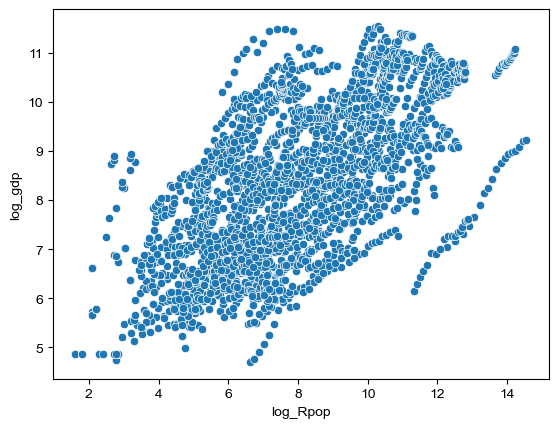

In [176]:
sns.scatterplot(data=df_complete, x='log_Rpop', y='log_gdp')

Explained variance ratio: [0.83206613 0.16793387]
Components shape: (2610, 2)


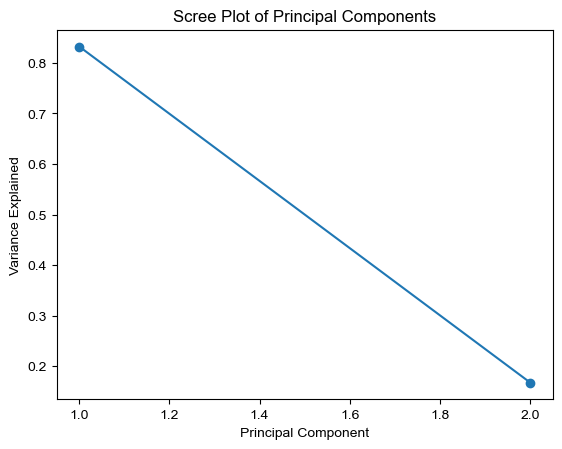

In [180]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select numeric covariates for PCA
X = df_complete[[ 'log_gdp',  'log_Rpop']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.95)  # retain components that explain 95% of variance
X_pca = pca.fit_transform(X_scaled)

import matplotlib.pyplot as plt

# Variance explained by each component
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Components shape:", X_pca.shape)

# Scree plot
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='o')
plt.title("Scree Plot of Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.show()


In [185]:
df_complete['PCA_0']=X_pca[:,0]
df_complete['PCA_1']=X_pca[:,1]

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
df_complete['treated:post']=df_complete['treated']*df_complete['post']
# Select the independent variables (excluding categorical variables handled by C())
independent_vars = df_complete[['treated', 'post', 'treated:post', 'PCA_0', 'PCA_1']]

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = independent_vars.columns
vif_data["VIF"] = [variance_inflation_factor(independent_vars.values, i) for i in range(len(independent_vars.columns))]
print(vif_data)

       Variable       VIF
0       treated  2.017188
1          post  1.091385
2  treated:post  2.076754
3         PCA_0  1.016656
4         PCA_1  1.009716


In [188]:
# Running the Difference-in-Differences regression
model = smf.ols("log_count ~ treated_CW * post+treated_GC * post+treated_GO* post +PCA_0+PCA_1+ C(Mention_country) + C(year)", data=df_complete).fit(cov_type='cluster', cov_kwds={'groups': df_complete['Mention_country']})
# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_count   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     24.15
Date:                Thu, 13 Mar 2025   Prob (F-statistic):           9.73e-38
Time:                        06:38:18   Log-Likelihood:                -3.6111
No. Observations:                2610   AIC:                             341.2
Df Residuals:                    2443   BIC:                             1321.
Df Model:                         166                                         
Covariance Type:              cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 170, but rank is 22
  warnings.warn('covariance of constraints does not have full '


In [194]:
# Assuming your dataframe is called df
# Step 1: Sort by country and year
df=df_complete.copy()
df = df.sort_values(by=['Mention_country', 'year'])

# Step 2: Create lagged versions of selected variables
df['log_count_lag1'] = df.groupby('Mention_country')['log_count'].shift(1)
df['log_gdp_lag1'] = df.groupby('Mention_country')['log_gdp'].shift(1)
df['log_population_lag1'] = df.groupby('Mention_country')['log_population'].shift(1)
df['log_Rpop_lag1'] = df.groupby('Mention_country')['log_Rpop'].shift(1)

# Step 3: Compute per-country correlation between variable and its lag
results = []
for country in df['Mention_country'].unique():
    country_df = df[df['Mention_country'] == country]
    corr = country_df[['log_count', 'log_count_lag1', 'log_gdp', 'log_gdp_lag1',
                       'log_population', 'log_population_lag1',
                       'log_Rpop', 'log_Rpop_lag1']].corr()
    results.append((country, corr))

# Step 4 (optional): Print or analyze specific correlations
for country, corr in results:
    print(f"== {country.upper()} ==")
    print(corr)
    print()


== AFG ==
                     log_count  log_count_lag1   log_gdp  log_gdp_lag1  \
log_count             1.000000        0.818050  0.898412      0.882167   
log_count_lag1        0.818050        1.000000  0.906238      0.924311   
log_gdp               0.898412        0.906238  1.000000      0.972042   
log_gdp_lag1          0.882167        0.924311  0.972042      1.000000   
log_population        0.884332        0.868394  0.825818      0.851912   
log_population_lag1   0.852647        0.867030  0.786366      0.853530   
log_Rpop              0.913368        0.899182  0.855344      0.860896   
log_Rpop_lag1         0.901032        0.900592  0.844106      0.889037   

                     log_population  log_population_lag1  log_Rpop  \
log_count                  0.884332             0.852647  0.913368   
log_count_lag1             0.868394             0.867030  0.899182   
log_gdp                    0.825818             0.786366  0.855344   
log_gdp_lag1               0.851912        

In [195]:
cor_table = []
for country in df['Mention_country'].unique():
    country_df = df[df['Mention_country'] == country]
    corr = country_df['log_count'].corr(country_df['log_count_lag1'])
    cor_table.append({'country': country, 'log_count_lag1_corr': corr})

cor_df = pd.DataFrame(cor_table)
print(cor_df.sort_values(by='log_count_lag1_corr', ascending=False))


    country  log_count_lag1_corr
70      kor             0.998067
58      ind             0.997303
25      chn             0.996916
22      can             0.996358
62      ita             0.995935
..      ...                  ...
40      eri             0.387376
119     slv             0.323528
21      caf             0.071176
26      civ             0.053827
129     tkm            -0.242791

[145 rows x 2 columns]


<Axes: xlabel='log_count_lag1_corr', ylabel='Count'>

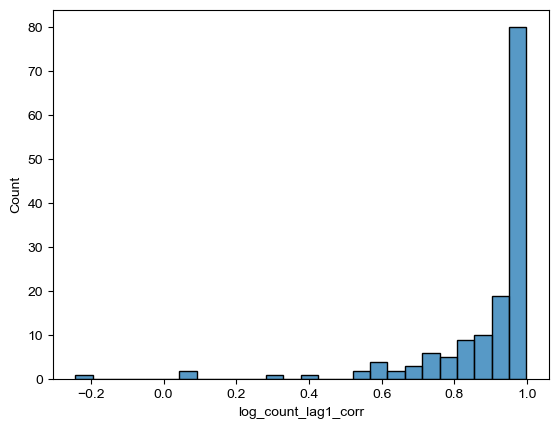

In [197]:
sns.histplot(cor_df, x='log_count_lag1_corr')

In [ ]:
x=np.arange(10)*10+2
x[:-1]

In [202]:
# Running the Difference-in-Differences regression
model = smf.ols("log_count ~ treated_CW * post+treated_GC * post+treated_GO* post +log_gdp+log_Rpop+ C(Mention_country) + C(year)", data=df_complete).fit(cov_type='cluster', cov_kwds={'groups': df_complete['Mention_country']})
# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_count   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     24.82
Date:                Thu, 13 Mar 2025   Prob (F-statistic):           2.17e-38
Time:                        06:56:26   Log-Likelihood:                -3.6111
No. Observations:                2610   AIC:                             341.2
Df Residuals:                    2443   BIC:                             1321.
Df Model:                         166                                         
Covariance Type:              cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 170, but rank is 22
  warnings.warn('covariance of constraints does not have full '


In [ ]:
from linearmodels.panel import ArellanoBond

df_model=df_complete.copy()
df_model['treated_CW_post'] = df_model['treated_CW'] * df_model['post']
df_model['treated_GC_post'] = df_model['treated_GC'] * df_model['post']
df_model['treated_GO_post'] = df_model['treated_GO'] * df_model['post']

ab_model = ArellanoBond(
    df_model['log_count'],
    exog=df_model[['log_gdp', 'log_Rpop', 'treated_CW', 'treated_GC', 'treated_GO', 'post', 'treated_CW_post', 'treated_GC_post', 'treated_GO_post']],
    lags=1
)

ab_results = ab_model.fit()
print(ab_results.summary)

ImportError: cannot import name 'DynamicPanelGMM' from 'linearmodels.panel' (c:\Users\Yasaman\anaconda3\Lib\site-packages\linearmodels\panel\__init__.py)

In [203]:
# Running the Difference-in-Differences regression
model = smf.ols("log_count ~ treated_CW * post+treated_GC * post+treated_GO* post +log_gdp+log_Rpop", data=df_complete).fit(cov_type='cluster', cov_kwds={'groups': df_complete['Mention_country']})
# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_count   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     1592.
Date:                Thu, 13 Mar 2025   Prob (F-statistic):          2.02e-139
Time:                        06:56:31   Log-Likelihood:                -2263.1
No. Observations:                2610   AIC:                             4546.
Df Residuals:                    2600   BIC:                             4605.
Df Model:                           9                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.4518      0.217     

In [189]:
# Running the Difference-in-Differences regression
model = smf.ols("log_count ~ treated * post + PCA_0 + PCA_1  + C(Mention_country) + C(year)", data=df_complete).fit(cov_type='HC1')
# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_count   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     3215.
Date:                Thu, 13 Mar 2025   Prob (F-statistic):               0.00
Time:                        06:40:06   Log-Likelihood:                -11.233
No. Observations:                2610   AIC:                             352.5
Df Residuals:                    2445   BIC:                             1321.
Df Model:                         164                                         
Covariance Type:                  HC1                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 166, but rank is 164
  warnings.warn('covariance of constraints does not have full '


In [126]:
# Running the Difference-in-Differences regression
model = smf.ols("log_count ~ treated * post + log_gdp + log_Rpop  + C(Mention_country) + C(year)", data=df_complete[df_complete['region']=='Middle East & North Africa']).fit(cov_type='HC1')
# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_count   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     656.6
Date:                Wed, 12 Mar 2025   Prob (F-statistic):          2.15e-281
Time:                        14:09:34   Log-Likelihood:                 47.962
No. Observations:                 360   AIC:                            -15.92
Df Residuals:                     320   BIC:                             139.5
Df Model:                          39                                         
Covariance Type:                  HC1                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 41, but rank is 39
  warnings.warn('covariance of constraints does not have full '


# Foreign attention

In [160]:

df = pd.read_csv(r"C:\Users\Yasaman\Downloads\Attention-fractional counting.csv")
df.rename(columns={'aggregated_value': 'count', 'country': 'Mention_country', 'affiliation_country': 'Aff_country'}, inplace=True)
df = df[df['year'].isin(np.arange(2002, 2020))]
Country_list={'Egypt':'EGY', 'Tunisia':'TUN','Libya':'LBY','Syria':'SYR','Yemen':'YEM','Bahrain':'BHR','Jordan':'JOR','Kuwait':'KWT','Morocco':'MAR','Oman':'OMN'}
rev_Country_list={Country_list[key]: key for key in Country_list}
abbr=[country.lower() for country in Country_list.values()]
physical_sciences=['MATH', 'ENGI', 'PHYS', 'COMP', 'MUL']
df=df[~df['subjarea'].isin(physical_sciences)]
df=df[df['Mention_country']!=df['Aff_country']]
df=df.groupby(['year', 'Mention_country'])['count'].sum().reset_index()


data=pd.read_csv(r"C:\Users\Yasaman\Downloads\scopus_2024_V1_scholarlymigration_country_enriched.csv")
data=data[data['year'].isin(np.arange(2002, 2020))]
data=data[['iso3code', 'incomelevel', 'gdp_per_capita', 'year', 'population', 'region', 'padded_population_of_researchers']].dropna()
data.rename(columns={'iso3code':'Mention_country'}, inplace=True)
data['Mention_country']=data['Mention_country'].apply(lambda x: x.lower())
df=df.merge(data, on=['Mention_country', 'year'], how='outer')
df=df[df['Mention_country'].isin(possible_iso)]


countries_to_remove=[]
for c  in df['Mention_country'].unique():
    if ((~df['count'].isna()) & (df['Mention_country'] == c)).sum()<15:
        countries_to_remove.append(c)
        print(c)

print(len(countries_to_remove))



# Define the required year range
required_years = list(range(2002, 2020))

# Get the unique countries
unique_countries = df["Mention_country"].unique()

# Create a complete DataFrame with all country-year combinations
full_data = []
for country in unique_countries:
    country_data = df[df["Mention_country"] == country]
    existing_years = set(country_data["year"])
    
    for year in required_years:
        if year in existing_years:
            row = country_data[country_data["year"] == year].iloc[0].to_dict()
        else:
            row = {
                "year": year,
                "Mention_country": country,
                "count": 0,
                "incomelevel": country_data["incomelevel"].iloc[0] if not country_data.empty else np.nan,
                "gdp_per_capita": np.nan,
                "population": np.nan,
                "region": country_data["region"].iloc[0] if not country_data.empty else np.nan,
            }
        full_data.append(row)

# Convert to DataFrame
df_complete = pd.DataFrame(full_data)

df_complete['treated']=df_complete['Mention_country'].isin(abbr).astype(int)
df_complete['treated_CW']=df_complete['Mention_country'].isin(['yem', 'lby', 'syr']).astype(int)
df_complete['treated_GO']=df_complete['Mention_country'].isin(['egy', 'tun']).astype(int)
df_complete['treated_GC']=df_complete['Mention_country'].isin(['omn', 'kwt', 'bhr', 'mar','jor']).astype(int)
df_complete['post']=df_complete['year'].apply(lambda x: 0 if x>=2002 and x<=2010 else 1 )
df_complete['count']=df_complete['count'].fillna(0)
df_complete['log_count']=np.log(df_complete['count']+1)

df_complete[['incomelevel', 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']] = df_complete.groupby('Mention_country')[['incomelevel', 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']].ffill()
df_complete[['incomelevel', 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']] = df_complete.groupby('Mention_country')[['incomelevel', 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']].bfill()
df_complete['log_gdp']=np.log(df_complete['gdp_per_capita'])
df_complete['log_population']=np.log(df_complete['population'])
df_complete['log_Rpop']=np.log(df_complete['padded_population_of_researchers']+1)
df_complete=df_complete[df_complete['Mention_country'].isin(possible_iso)].reset_index(drop=True)


0


In [161]:
# Running the Difference-in-Differences regression
model = smf.ols("log_count ~ treated_CW * post+treated_GC * post+treated_GO* post +log_gdp+log_population+ C(Mention_country) + C(year)", data=df_complete).fit(cov_type='cluster', cov_kwds={'groups': df_complete['Mention_country']})
# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_count   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     64.53
Date:                Wed, 12 Mar 2025   Prob (F-statistic):           2.19e-63
Time:                        15:33:00   Log-Likelihood:                 810.65
No. Observations:                2610   AIC:                            -1287.
Df Residuals:                    2443   BIC:                            -307.5
Df Model:                         166                                         
Covariance Type:              cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 170, but rank is 22
  warnings.warn('covariance of constraints does not have full '


In [131]:

# Running the Difference-in-Differences regression
model = smf.ols("log_count ~ treated * post + log_gdp   + C(Mention_country) + C(year)", data=df_complete[df_complete['region']=='Middle East & North Africa']).fit(cov_type='HC1')
# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_count   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     331.0
Date:                Wed, 12 Mar 2025   Prob (F-statistic):          4.94e-234
Time:                        14:11:21   Log-Likelihood:                 87.482
No. Observations:                 360   AIC:                            -96.96
Df Residuals:                     321   BIC:                             54.59
Df Model:                          38                                         
Covariance Type:                  HC1                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 40, but rank is 38
  warnings.warn('covariance of constraints does not have full '


In [62]:
# Running the Difference-in-Differences regression
model = smf.ols("log_count ~ treated * post + log_gdp +log_population  + C(Mention_country) + C(year)", data=df_complete).fit(cov_type='HC1')
# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_count   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     2358.
Date:                Wed, 12 Mar 2025   Prob (F-statistic):               0.00
Time:                        13:21:11   Log-Likelihood:                 751.53
No. Observations:                2610   AIC:                            -1173.
Df Residuals:                    2445   BIC:                            -205.0
Df Model:                         164                                         
Covariance Type:                  HC1                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 166, but rank is 164
  warnings.warn('covariance of constraints does not have full '


# Domestic funding

In [162]:
#funding

physical_sciences=[ 'MATH', 'ENGI', 'PHYS', 'COMP','MULT']
df_fund=pd.read_csv(r"C:\Users\Yasaman\Downloads\Mentioned-Funding-fractional counting.csv")
df_fund.rename(columns={'aggregated_value': 'count', 'country': 'Mention_country', 'funding_country': 'Source'}, inplace=True)
df_fund=df_fund[~(df_fund['subjarea'].isin(physical_sciences))]
df_fund=df_fund[df_fund['Mention_country']==df_fund['Source']]
df_fund=df_fund.groupby(['year', 'Mention_country'])['count'].sum().reset_index()
df_fund=df_fund[(df_fund['year'].isin(np.arange(2002,2020,1)))].reset_index(drop=True)
df=df_fund.copy()

data=pd.read_csv(r"C:\Users\Yasaman\Downloads\scopus_2024_V1_scholarlymigration_country_enriched.csv")
data=data[data['year'].isin(np.arange(2002, 2020))]
data=data[['iso3code', 'incomelevel', 'gdp_per_capita', 'year', 'population', 'region', 'padded_population_of_researchers']].dropna()
data.rename(columns={'iso3code':'Mention_country'}, inplace=True)
data['Mention_country']=data['Mention_country'].apply(lambda x: x.lower())
df=df.merge(data, on=['Mention_country', 'year'], how='outer')
df=df[df['Mention_country'].isin(possible_iso)]


countries_to_remove=[]
for c  in df['Mention_country'].unique():
    if ((~df['count'].isna()) & (df['Mention_country'] == c)).sum()<15:
        countries_to_remove.append(c)
        print(c)

print(len(countries_to_remove))

# Define the required year range
required_years = list(range(2002, 2020))

# Get the unique countries
unique_countries = df["Mention_country"].unique()

# Create a complete DataFrame with all country-year combinations
full_data = []
for country in unique_countries:
    country_data = df[df["Mention_country"] == country]
    existing_years = set(country_data["year"])
    
    for year in required_years:
        if year in existing_years:
            row = country_data[country_data["year"] == year].iloc[0].to_dict()
        else:
            row = {
                "year": year,
                "Mention_country": country,
                "count": 0,
                "incomelevel": country_data["incomelevel"].iloc[0] if not country_data.empty else np.nan,
                "gdp_per_capita": np.nan,
                "population": np.nan,
                "region": country_data["region"].iloc[0] if not country_data.empty else np.nan,
            }
        full_data.append(row)

# Convert to DataFrame
df_complete = pd.DataFrame(full_data)

df_complete['treated']=df_complete['Mention_country'].isin(abbr).astype(int)
df_complete['treated_CW']=df_complete['Mention_country'].isin(['yem', 'lby', 'syr']).astype(int)
df_complete['treated_GO']=df_complete['Mention_country'].isin(['egy', 'tun']).astype(int)
df_complete['treated_GC']=df_complete['Mention_country'].isin(['omn', 'kwt', 'bhr', 'mar','jor']).astype(int)
df_complete['post']=df_complete['year'].apply(lambda x: 0 if x>=2002 and x<=2010 else 1 )
df_complete['count']=df_complete['count'].fillna(0)
df_complete['log_count']=np.log(df_complete['count']+1)

df_complete[['incomelevel', 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']] = df_complete.groupby('Mention_country')[['incomelevel', 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']].ffill()
df_complete[['incomelevel', 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']] = df_complete.groupby('Mention_country')[['incomelevel', 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']].bfill()
df_complete['log_gdp']=np.log(df_complete['gdp_per_capita'])
df_complete['log_population']=np.log(df_complete['population'])
df_complete['log_Rpop']=np.log(df_complete['padded_population_of_researchers']+1)
df_complete=df_complete[df_complete['Mention_country'].isin(possible_iso)].reset_index(drop=True)




afg
ago
alb
arm
aze
bdi
ben
bfa
bhr
bih
blr
bol
caf
civ
cmr
dji
dom
dza
eri
gab
gmb
gtm
hnd
hti
irq
jam
kaz
kgz
khm
lao
lbr
lby
lso
mda
mdg
mkd
mli
mmr
mng
moz
mrt
mus
mwi
nam
ner
nic
pan
pry
pse
qat
rwa
sen
sle
slv
som
syr
tcd
tgo
tjk
tkm
tto
uzb
yem
zmb
64


In [164]:
# Running the Difference-in-Differences regression
model = smf.ols("log_count ~ treated_CW * post+treated_GC * post+treated_GO* post + C(Mention_country) + C(year)", data=df_complete).fit(cov_type='cluster', cov_kwds={'groups': df_complete['Mention_country']})
# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_count   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     26.02
Date:                Wed, 12 Mar 2025   Prob (F-statistic):           4.61e-38
Time:                        15:36:29   Log-Likelihood:                -1960.9
No. Observations:                2610   AIC:                             4252.
Df Residuals:                    2445   BIC:                             5220.
Df Model:                         164                                         
Covariance Type:              cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 168, but rank is 20
  warnings.warn('covariance of constraints does not have full '


In [134]:
# Running the Difference-in-Differences regression
model = smf.ols("log_count ~ treated * post   + C(Mention_country) + C(year)", data=df_complete[df_complete['region']=='Middle East & North Africa']).fit(cov_type='HC1')
# Print summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              log_count   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     107.6
Date:                Wed, 12 Mar 2025   Prob (F-statistic):          9.68e-159
Time:                        14:13:33   Log-Likelihood:                -278.62
No. Observations:                 360   AIC:                             633.2
Df Residuals:                     322   BIC:                             780.9
Df Model:                          37                                         
Covariance Type:                  HC1                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 39, but rank is 37
  warnings.warn('covariance of constraints does not have full '


In [121]:
# Running the Difference-in-Differences regression
model = smf.ols("log_count ~ treated * post + log_gdp  + C(Mention_country) + C(year)", data=df_complete).fit(cov_type='HC1')
# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_count   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     1049.
Date:                Wed, 12 Mar 2025   Prob (F-statistic):               0.00
Time:                        14:08:06   Log-Likelihood:                -1984.8
No. Observations:                2610   AIC:                             4298.
Df Residuals:                    2446   BIC:                             5260.
Df Model:                         163                                         
Covariance Type:                  HC1                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 165, but rank is 163
  warnings.warn('covariance of constraints does not have full '


# Foriegn funding

In [165]:
#funding

physical_sciences=[ 'MATH', 'ENGI', 'PHYS', 'COMP','MULT']
df_fund=pd.read_csv(r"C:\Users\Yasaman\Downloads\Mentioned-Funding-fractional counting.csv")
df_fund.rename(columns={'aggregated_value': 'count', 'country': 'Mention_country', 'funding_country': 'Source'}, inplace=True)
df_fund=df_fund[~(df_fund['subjarea'].isin(physical_sciences))]
df_fund=df_fund[df_fund['Mention_country']!=df_fund['Source']]
df_fund=df_fund.groupby(['year', 'Mention_country'])['count'].sum().reset_index()
df_fund=df_fund[(df_fund['year'].isin(np.arange(2002,2020,1)))].reset_index(drop=True)
df=df_fund.copy()

data=pd.read_csv(r"C:\Users\Yasaman\Downloads\scopus_2024_V1_scholarlymigration_country_enriched.csv")
data=data[data['year'].isin(np.arange(2002, 2020))]
data=data[['iso3code', 'incomelevel', 'gdp_per_capita', 'year', 'population', 'region', 'padded_population_of_researchers']].dropna()
data.rename(columns={'iso3code':'Mention_country'}, inplace=True)
data['Mention_country']=data['Mention_country'].apply(lambda x: x.lower())
df=df.merge(data, on=['Mention_country', 'year'], how='outer')
df=df[df['Mention_country'].isin(possible_iso)]


countries_to_remove=[]
for c  in df['Mention_country'].unique():
    if ((~df['count'].isna()) & (df['Mention_country'] == c)).sum()<15:
        countries_to_remove.append(c)
        print(c)

print(len(countries_to_remove))



# Define the required year range
required_years = list(range(2002, 2020))

# Get the unique countries
unique_countries = df["Mention_country"].unique()

# Create a complete DataFrame with all country-year combinations
full_data = []
for country in unique_countries:
    country_data = df[df["Mention_country"] == country]
    existing_years = set(country_data["year"])
    
    for year in required_years:
        if year in existing_years:
            row = country_data[country_data["year"] == year].iloc[0].to_dict()
        else:
            row = {
                "year": year,
                "Mention_country": country,
                "count": 0,
                "incomelevel": country_data["incomelevel"].iloc[0] if not country_data.empty else np.nan,
                "gdp_per_capita": np.nan,
                "population": np.nan,
                "region": country_data["region"].iloc[0] if not country_data.empty else np.nan,
            }
        full_data.append(row)

# Convert to DataFrame
df_complete = pd.DataFrame(full_data)

df_complete['treated']=df_complete['Mention_country'].isin(abbr).astype(int)
df_complete['treated_CW']=df_complete['Mention_country'].isin(['yem', 'lby', 'syr']).astype(int)
df_complete['treated_GO']=df_complete['Mention_country'].isin(['egy', 'tun']).astype(int)
df_complete['treated_GC']=df_complete['Mention_country'].isin(['omn', 'kwt', 'bhr', 'mar','jor']).astype(int)
df_complete['post']=df_complete['year'].apply(lambda x: 0 if x>=2002 and x<=2010 else 1 )
df_complete['count']=df_complete['count'].fillna(0)
df_complete['log_count']=np.log(df_complete['count']+1)

df_complete[['incomelevel', 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']] = df_complete.groupby('Mention_country')[['incomelevel', 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']].ffill()
df_complete[['incomelevel', 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']] = df_complete.groupby('Mention_country')[['incomelevel', 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']].bfill()
df_complete['log_gdp']=np.log(df_complete['gdp_per_capita'])
df_complete['log_population']=np.log(df_complete['population'])
df_complete['log_Rpop']=np.log(df_complete['padded_population_of_researchers']+1)
df_complete=df_complete[df_complete['Mention_country'].isin(possible_iso)].reset_index(drop=True)


0


In [166]:
# Running the Difference-in-Differences regression
model = smf.ols("log_count ~ treated_CW * post+treated_GC * post+treated_GO* post + C(Mention_country) + C(year)", data=df_complete).fit(cov_type='cluster', cov_kwds={'groups': df_complete['Mention_country']})
# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_count   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     251.1
Date:                Wed, 12 Mar 2025   Prob (F-statistic):          2.32e-101
Time:                        15:38:41   Log-Likelihood:                -364.79
No. Observations:                2610   AIC:                             1060.
Df Residuals:                    2445   BIC:                             2028.
Df Model:                         164                                         
Covariance Type:              cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 168, but rank is 20
  warnings.warn('covariance of constraints does not have full '


In [143]:

# Running the Difference-in-Differences regression
model = smf.ols("log_count ~ treated * post   + C(Mention_country) + C(year)", data=df_complete[df_complete['region']=='Middle East & North Africa']).fit(cov_type='HC1')
# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_count   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     181.3
Date:                Wed, 12 Mar 2025   Prob (F-statistic):          8.31e-193
Time:                        14:18:11   Log-Likelihood:                -89.120
No. Observations:                 360   AIC:                             254.2
Df Residuals:                     322   BIC:                             401.9
Df Model:                          37                                         
Covariance Type:                  HC1                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 39, but rank is 37
  warnings.warn('covariance of constraints does not have full '


In [93]:
# Running the Difference-in-Differences regression
model = smf.ols("log_count ~ treated * post + log_gdp+log_population  + C(Mention_country) + C(year)", data=df_complete).fit(cov_type='HC1')
# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_count   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     899.9
Date:                Wed, 12 Mar 2025   Prob (F-statistic):               0.00
Time:                        13:42:44   Log-Likelihood:                -342.07
No. Observations:                2610   AIC:                             1014.
Df Residuals:                    2445   BIC:                             1982.
Df Model:                         164                                         
Covariance Type:                  HC1                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 166, but rank is 164
  warnings.warn('covariance of constraints does not have full '


# Emigration



In [167]:
#migration

data=pd.read_csv(r"C:\Users\Yasaman\Downloads\scopus_2024_V1_scholarlymigration_country_enriched.csv")
data=data[data['year'].isin(np.arange(2002, 2020))]
data=data[['iso3code', 'incomelevel', 'gdp_per_capita', 'year', 'population', 'region', 'padded_population_of_researchers', 'outmigrationrate','netmigrationrate','number_of_outmigrations']].dropna()
data.rename(columns={'iso3code':'Mention_country'}, inplace=True)
data['Mention_country']=data['Mention_country'].apply(lambda x: x.lower())
df=data.copy()
df=df[df['Mention_country'].isin(possible_iso)]



# Define the required year range
required_years = list(range(2002, 2020))

# Get the unique countries
unique_countries = df["Mention_country"].unique()

# Create a complete DataFrame with all country-year combinations
full_data = []
for country in unique_countries:
    country_data = df[df["Mention_country"] == country]
    existing_years = set(country_data["year"])
    
    for year in required_years:
        if year in existing_years:
            row = country_data[country_data["year"] == year].iloc[0].to_dict()
        else:
            row = {
                "year": year,
                "Mention_country": country,
                "padded_population_of_researchers": 0,
                "incomelevel": country_data["incomelevel"].iloc[0] if not country_data.empty else np.nan,
                "gdp_per_capita": np.nan,
                "population": np.nan,
                "region": country_data["region"].iloc[0] if not country_data.empty else np.nan,
            }
        full_data.append(row)

# Convert to DataFrame
df_complete = pd.DataFrame(full_data)

df_complete['treated']=df_complete['Mention_country'].isin(abbr).astype(int)
df_complete['treated_CW']=df_complete['Mention_country'].isin(['yem', 'lby', 'syr']).astype(int)
df_complete['treated_GO']=df_complete['Mention_country'].isin(['egy', 'tun']).astype(int)
df_complete['treated_GC']=df_complete['Mention_country'].isin(['omn', 'kwt', 'bhr', 'mar','jor']).astype(int)

df_complete['post']=df_complete['year'].apply(lambda x: 0 if x>=2002 and x<=2010 else 1 )
df_complete['count']=df_complete['number_of_outmigrations'].fillna(0)
df_complete['log_count']=np.log(df_complete['count']+1)


columns_to_fill=['incomelevel', 'gdp_per_capita', 'population', 'region',
       'padded_population_of_researchers', 'outmigrationrate',
       'netmigrationrate', 'number_of_outmigrations',]
df_complete[columns_to_fill] = df_complete.groupby('Mention_country')[columns_to_fill].ffill()
df_complete[columns_to_fill] = df_complete.groupby('Mention_country')[columns_to_fill].bfill()
df_complete['log_gdp']=np.log(df_complete['gdp_per_capita'])
df_complete['log_population']=np.log(df_complete['population'])
df_complete['log_Rpop']=np.log(df_complete['padded_population_of_researchers']+1)
df_complete=df_complete[df_complete['Mention_country'].isin(possible_iso)].reset_index(drop=True)

In [169]:
# Running the Difference-in-Differences regression
model = smf.ols("netmigrationrate ~ treated_CW * post+treated_GC * post+treated_GO* post +log_gdp+ C(Mention_country) + C(year)", data=df_complete).fit(cov_type='cluster', cov_kwds={'groups': df_complete['Mention_country']})
# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       netmigrationrate   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     4.791
Date:                Wed, 12 Mar 2025   Prob (F-statistic):           5.38e-09
Time:                        15:46:34   Log-Likelihood:                 5636.0
No. Observations:                2610   AIC:                        -1.094e+04
Df Residuals:                    2444   BIC:                            -9966.
Df Model:                         165                                         
Covariance Type:              cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 169, but rank is 21
  warnings.warn('covariance of constraints does not have full '


In [149]:
model = smf.ols("netmigrationrate ~ treated * post +log_Rpop  + C(Mention_country) + C(year)", data=df_complete[df_complete['region']=='Middle East & North Africa']).fit(cov_type='HC1')
# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       netmigrationrate   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     21.71
Date:                Wed, 12 Mar 2025   Prob (F-statistic):           1.22e-67
Time:                        14:21:41   Log-Likelihood:                 860.02
No. Observations:                 360   AIC:                            -1642.
Df Residuals:                     321   BIC:                            -1490.
Df Model:                          38                                         
Covariance Type:                  HC1                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 40, but rank is 38
  warnings.warn('covariance of constraints does not have full '


In [119]:
# Running the Difference-in-Differences regression
model = smf.ols("netmigrationrate ~ treated * post + log_gdp+log_Rpop  + C(Mention_country) + C(year)", data=df_complete).fit(cov_type='HC1')
# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       netmigrationrate   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     15.31
Date:                Wed, 12 Mar 2025   Prob (F-statistic):          2.51e-269
Time:                        14:07:07   Log-Likelihood:                 5639.9
No. Observations:                2610   AIC:                        -1.095e+04
Df Residuals:                    2445   BIC:                            -9982.
Df Model:                         164                                         
Covariance Type:                  HC1                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 166, but rank is 164
  warnings.warn('covariance of constraints does not have full '
